In [1]:
!git clone https://github.com/tareknaous/readme.git

Cloning into 'readme'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 71 (delta 14), reused 23 (delta 0), pack-reused 0
Receiving objects: 100% (71/71), 1.96 MiB | 35.12 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [2]:
import os
os.system("""wget "https://getfile.dokpub.com/yandex/get/https://disk.yandex.com/d/UN5pmzv66OM1Pg" -O model_en""")

0

In [4]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from torch.utils.data import DataLoader, SequentialSampler

from transformers import BertForSequenceClassification
import pandas as pd
import numpy as np

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                              do_lower_case=True)
def load_data(language = 'en'):
    data = pd.concat([pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_train.xlsx'), pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_val.xlsx'), pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_test.xlsx')], axis=0)
    return data

def make_dataloader(data, n_samples_per_class = 40, batch_size = 3):

    label_dict = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


    data_lang = pd.DataFrame(columns=['text', 'label'])
    data_lang['text'] = data['Sentence']
    data_lang['label'] = data['Rating'].replace(label_dict)


    samples_list = []
    for label in label_dict.values():
        samples = data_lang[data_lang['label'] == label].sample(n=n_samples_per_class, replace=False)
        samples_list.append(samples)

    data_lang = pd.concat(samples_list)

    encoded_lang = tokenizer.batch_encode_plus(
        data_lang['text'].values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    input_ids_predict = encoded_lang['input_ids']
    attention_masks_predict = encoded_lang['attention_mask']
    labels_predict = torch.tensor(data_lang['label'].values)

    dataset_lang = TensorDataset(input_ids_predict, attention_masks_predict, labels_predict)


    dataloader_lang = DataLoader(dataset_lang,
                                  sampler=SequentialSampler(dataset_lang),
                                  batch_size=batch_size)
    return dataloader_lang

In [7]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
stete_dict = torch.load("./model_en", map_location='cpu')
model.load_state_dict(stete_dict)

device = "cpu"
if torch.cuda.is_available(): device = "cuda"

model = model.to(device)

In [7]:
# def get_neurons_activations(dataloader):

#     model.eval()

#     hidens_per_layer = [[] for _ in range(13)]

#     for batch in dataloader:
#         batch = tuple(b.to(device) for b in batch)
#         inputs = {'input_ids':      batch[0],
#                   'attention_mask': batch[1],
#                   'labels':         batch[2],
#                  }

#         with torch.no_grad():
#             outputs = model(**inputs)

#         for layer_idx, layer_hidden_states in enumerate(outputs['hidden_states']):
#             hidens_per_layer[layer_idx].append(layer_hidden_states)

#     hidens_stacked_per_layer = [torch.cat(layer_hidens, dim=0) for layer_hidens in hidens_per_layer]

#     all_hidens_tensor = torch.stack(hidens_stacked_per_layer)

#     return all_hidens_tensor # [layers, batch, token, neurons]

In [9]:
def get_neurons_activations(dataloader):
    model.eval()

    # Подготовка списка для хранения усредненных скрытых состояний по слоям
    avg_hidens_per_layer = [[] for _ in range(13)]  # предполагается, что у модели 12 слоев + входной слой

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        # Создание маски для исключения [PAD] токенов (где input_ids равно 0)
        mask = inputs['input_ids'] != 0  # Создается маска размером как input_ids, True где не PAD
        mask = mask.unsqueeze(-1).expand_as(outputs['hidden_states'][0])  # Расширение маски до размера скрытых состояний

        for layer_idx, layer_hidden_states in enumerate(outputs['hidden_states']):
            # Применение маски к скрытым состояниям
            masked_hidden_states = layer_hidden_states * mask.float()
            # Вычисление суммы и количества не-pad токенов для усреднения
            sum_hidden_states = masked_hidden_states.sum(dim=1)  # Сумма по оси токенов
            non_pad_tokens = mask.sum(dim=1)  # Количество не-pad токенов
            # Усреднение скрытых состояний, исключая pad-токены
            avg_hidden_states = sum_hidden_states / non_pad_tokens.clamp(min=1)  # Избегание деления на 0
            avg_hidens_per_layer[layer_idx].append(avg_hidden_states)

    # Собираем усредненные скрытые состояния по всему датасету для каждого слоя
    avg_hidens_stacked_per_layer = [torch.cat(layer_avg_hidens, dim=0) for layer_avg_hidens in avg_hidens_per_layer]

    # Стекинг усредненных скрытых состояний для всех слоев
    all_avg_hidens_tensor = torch.stack(avg_hidens_stacked_per_layer)

    return all_avg_hidens_tensor # [layers, batch, neurons]


In [10]:
def pearson_corr(x, y):

    return (torch.dot(x, y)/(torch.norm(x)*torch.norm(y))).item()

def ANC(L1, L2):
    X = L1 - L1.mean(dim=0, keepdim=True)
    Y = L2 - L2.mean(dim=0, keepdim=True)

    anc = 0
    for i in range(X.size()[0]):
        anc+=abs(pearson_corr(X[i], Y[i]))

    return anc/X.size()[0]

def count_ANC(layers1, layers2):
    anc = []
    for i in range(13):
        anc.append(ANC(layers1[i], layers2[i]))

    return anc

In [12]:
dataloader_en = make_dataloader(load_data('en'))
layers_en = get_neurons_activations(dataloader_en)
torch.cuda.empty_cache()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
data_ANC = []
languages = ['ru', 'fr', 'hi', 'ar']

for lang in languages:
    data = load_data(lang)
    for i in range(10):
        dataloader_compare = make_dataloader(data)
        layers_compare = get_neurons_activations(dataloader_compare)
        torch.cuda.empty_cache()

        ANC_counted = count_ANC(layers_en, layers_compare)

        data_ANC.append({
            'Value': ANC_counted,
            'Language Pair': f'en-{lang}'
        })

df = pd.DataFrame(data_ANC)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [17]:
df.head()

,Value,Language Pair
0,"[0.07397708635471645, 0.08205114824965373, 0.1...",en-ru
1,"[0.07786579574846351, 0.08875886970381544, 0.1...",en-ru
2,"[0.08384726812549465, 0.09141182068900283, 0.1...",en-ru
3,"[0.0785745766062367, 0.09065624280289436, 0.11...",en-ru
4,"[0.07817776491210679, 0.08261759866145439, 0.1...",en-ru


In [18]:
df.to_csv(f'ANC_Readme.txt', index=False, sep=';')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

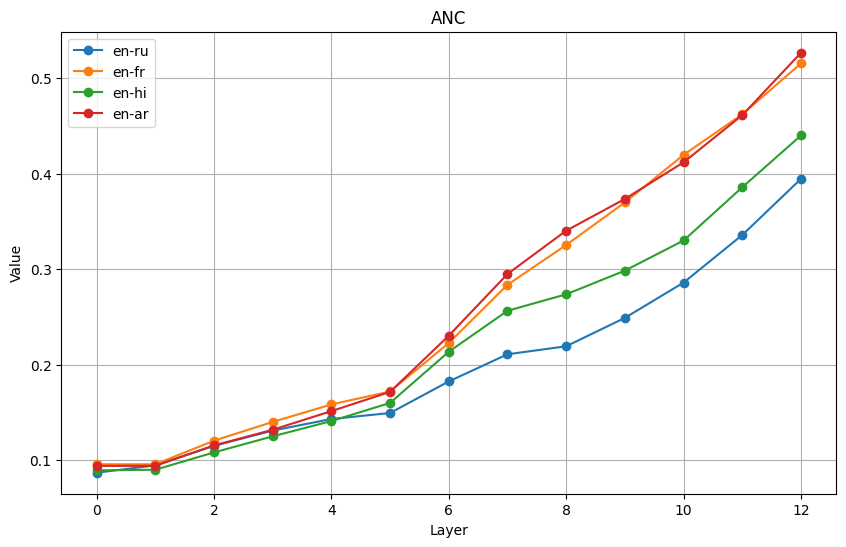

In [10]:
import matplotlib.pyplot as plt

x = np.arange(0, 13)

plt.figure(figsize=(10, 6))

for lang in ['ru', 'fr', 'hi', 'ar']:
    dataloader_compare = make_dataloader(lang)
    layers_compare = get_neurons_activations(dataloader_compare)
    torch.cuda.empty_cache()

    ANC_counted = count_ANC(layers_en, layers_compare)

    plt.plot(x, ANC_counted, label=f'en-{lang}', marker='o')

plt.title('ANC')
plt.xlabel('Layer')
plt.ylabel('Value')
plt.legend()

plt.grid(True)
plt.show()


In [10]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def plot_confusion_matrix(preds, labels, label_dict):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    label_to_name = {value: key for key, value in label_dict.items()}

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)
    label_names = list(label_dict.keys()) #['Easy', 'Normal']
    #label_names = ['Very Easy', 'Easy', 'Normal', 'Hard', 'Very Hard']#[label_to_name.get(label, "Unknown") for label in np.unique(labels_flat)]

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names[::-1])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинные классы')
    plt.xlabel('Предсказанные классы')
    plt.show()


def metrics_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)

    for label in np.unique(labels_flat):
        # True Positives
        TP = cm[label, label]
        # False Positives: sum of the corresponding column minus TP
        FP = np.sum(cm[:, label]) - TP
        # False Negatives: sum of the corresponding row minus TP
        FN = np.sum(cm[label, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {TP}/{TP+FN} (True Positives / Total Actual Positives)')
        tqdm.write(f'Precision: {precision:.2f}')
        tqdm.write(f'Recall: {recall:.2f}')
        tqdm.write(f'F1 Score: {f1:.2f}\n')

In [13]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [15]:
def eval_prediction(dataloader):
    label_dict = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

    predict_loss, predictions, true_predict = evaluate(dataloader)
    predict_f1 = f1_score_func(predictions, true_predict)
    print(f'F1 Score (Weighted): {predict_f1:.2f}')
    plot_confusion_matrix(predictions, true_predict, label_dict)
    metrics_per_class(predictions, true_predict, label_dict)

ru


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


F1 Score (Weighted): 0.24


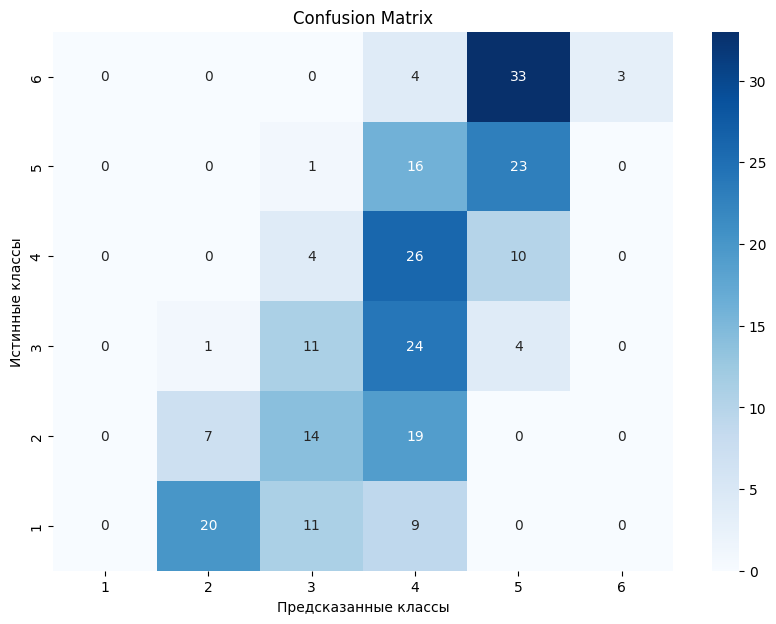

Class: 1
Accuracy: 0/40 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 7/40 (True Positives / Total Actual Positives)
Precision: 0.25
Recall: 0.17
F1 Score: 0.21

Class: 3
Accuracy: 11/40 (True Positives / Total Actual Positives)
Precision: 0.27
Recall: 0.28
F1 Score: 0.27

Class: 4
Accuracy: 26/40 (True Positives / Total Actual Positives)
Precision: 0.27
Recall: 0.65
F1 Score: 0.38

Class: 5
Accuracy: 23/40 (True Positives / Total Actual Positives)
Precision: 0.33
Recall: 0.57
F1 Score: 0.42

Class: 6
Accuracy: 3/40 (True Positives / Total Actual Positives)
Precision: 1.00
Recall: 0.07
F1 Score: 0.14

fr


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


F1 Score (Weighted): 0.28


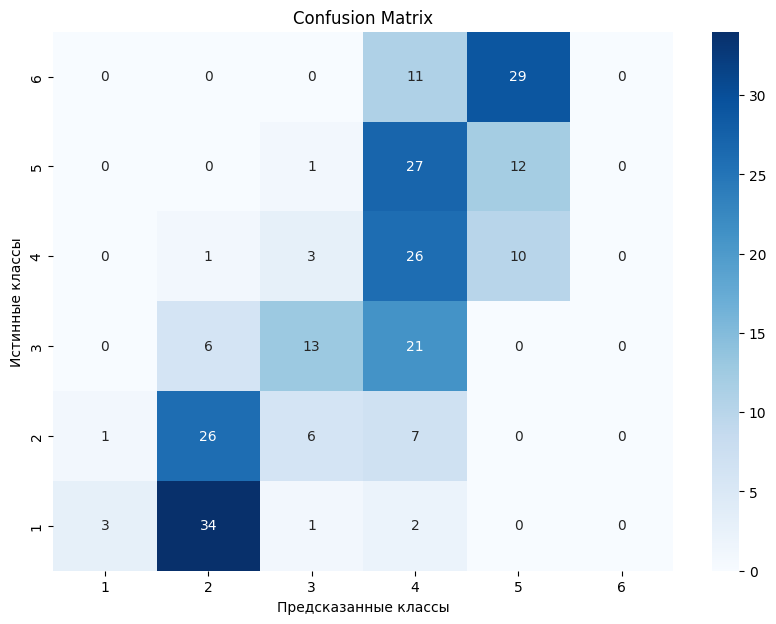

Class: 1
Accuracy: 3/40 (True Positives / Total Actual Positives)
Precision: 0.75
Recall: 0.07
F1 Score: 0.14

Class: 2
Accuracy: 26/40 (True Positives / Total Actual Positives)
Precision: 0.39
Recall: 0.65
F1 Score: 0.49

Class: 3
Accuracy: 13/40 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.33
F1 Score: 0.41

Class: 4
Accuracy: 26/40 (True Positives / Total Actual Positives)
Precision: 0.28
Recall: 0.65
F1 Score: 0.39

Class: 5
Accuracy: 12/40 (True Positives / Total Actual Positives)
Precision: 0.24
Recall: 0.30
F1 Score: 0.26

Class: 6
Accuracy: 0/40 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

hi


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


F1 Score (Weighted): 0.21


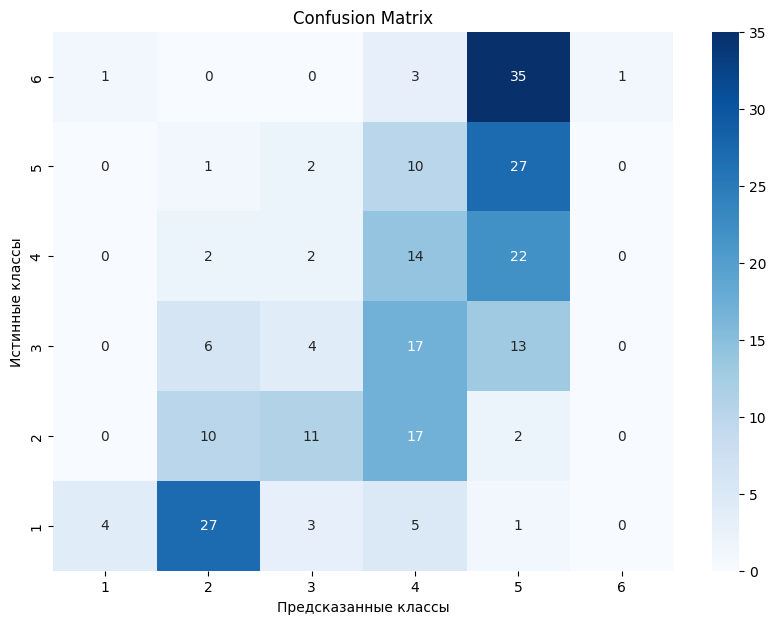

Class: 1
Accuracy: 4/40 (True Positives / Total Actual Positives)
Precision: 0.80
Recall: 0.10
F1 Score: 0.18

Class: 2
Accuracy: 10/40 (True Positives / Total Actual Positives)
Precision: 0.22
Recall: 0.25
F1 Score: 0.23

Class: 3
Accuracy: 4/40 (True Positives / Total Actual Positives)
Precision: 0.18
Recall: 0.10
F1 Score: 0.13

Class: 4
Accuracy: 14/40 (True Positives / Total Actual Positives)
Precision: 0.21
Recall: 0.35
F1 Score: 0.26

Class: 5
Accuracy: 27/40 (True Positives / Total Actual Positives)
Precision: 0.27
Recall: 0.68
F1 Score: 0.39

Class: 6
Accuracy: 1/40 (True Positives / Total Actual Positives)
Precision: 1.00
Recall: 0.03
F1 Score: 0.05

ar


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


F1 Score (Weighted): 0.33


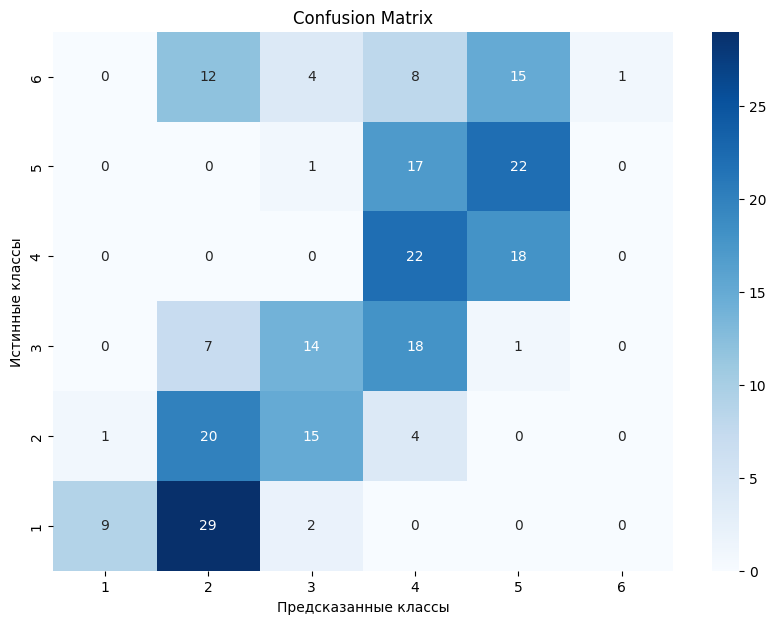

Class: 1
Accuracy: 9/40 (True Positives / Total Actual Positives)
Precision: 0.90
Recall: 0.23
F1 Score: 0.36

Class: 2
Accuracy: 20/40 (True Positives / Total Actual Positives)
Precision: 0.29
Recall: 0.50
F1 Score: 0.37

Class: 3
Accuracy: 14/40 (True Positives / Total Actual Positives)
Precision: 0.39
Recall: 0.35
F1 Score: 0.37

Class: 4
Accuracy: 22/40 (True Positives / Total Actual Positives)
Precision: 0.32
Recall: 0.55
F1 Score: 0.40

Class: 5
Accuracy: 22/40 (True Positives / Total Actual Positives)
Precision: 0.39
Recall: 0.55
F1 Score: 0.46

Class: 6
Accuracy: 1/40 (True Positives / Total Actual Positives)
Precision: 1.00
Recall: 0.03
F1 Score: 0.05



In [16]:
for lang in ['ru', 'fr', 'hi', 'ar']:
    print(lang)
    dataloader = make_dataloader(lang)
    eval_prediction(dataloader)